In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#读取数据
data=pd.read_excel(r"C:\Users\admin\Desktop\金融计量经济学\实验研究2\PredictorData2017.xlsx",sheet_name="Monthly")
df=data.iloc[671:]

In [33]:
#数据处理

# equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
df['premium'] = df['CRSP_SPvw'] - df['Rfree']

# Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices. 
df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

# Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
df['d/y'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

# Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

# Dividend Payout Ratio (d/e) is the difference between the log of dividends and the log of earnings.
# df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

# Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
# df['tms'] = df['lty'] - df['tbl']

# Default Yield Spread (dfy): is the difference between BAA- and AAA- rated cor- porate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# Default Return Spread (dfr): is the difference between the return on long-term corporate bonds and returns on the long-term government bonds.
df['dfr'] = df['corpr'] - df['ltr']

df=df.iloc[1:,]

E:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
E:\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [34]:
#历史均值模型
premium_average=[]
for i in range(len(df)-20*12):
    premium_average.append(df['premium'][:i+20*12].mean())

In [35]:
#OLS递归预测
def OLS(name):
    premium_OLS=[]
    for i in range(len(df)-20*12):
        y=df["premium"][1:i+20*12].values
        X=sm.add_constant(df[name][0:i+20*12-1].values)
        model=sm.OLS(y,X)
        res=model.fit()
        premium_OLS.append(res.predict(np.array([1,float(df[name][i+20*12-1:i+20*12])]))[0])
    return premium_OLS

#TWLS递归预测
def TWLS(name):
    p=0.5
    premium_TWLS=[]
    for i in range(len(df)-20*12):
        WSPE_sum=[]
        for j in range(101):
            nba=j*0.1
            y=df["premium"][1:int((i+20*12)*p)].values
            X=sm.add_constant(df[name][0:int((i+20*12)*p)-1].values)
            model=sm.WLS(y,X,np.power(range(2,int((i+20*12)*p)+1),nba))
            res=model.fit()
            WSPE_fenzi=sum(np.power(range(int((i+20*12)*p)+1,i+20*12+1),nba)*
                 np.power(df['premium'][int((i+20*12)*p):i+20*12].values
            -(res.params[0]+res.params[1]*df[name][int((i+20*12)*p)-1:i+20*12-1].values),2))
            WSPE_fenmu=sum(np.power(range(int((i+20*12)*p)+1,i+20*12+1),nba))
            WSPE_sum.append(WSPE_fenzi/WSPE_fenmu)
        nba=0.1*WSPE_sum.index(min(WSPE_sum))
        y=df["premium"][1:i+20*12].values
        X=sm.add_constant(df[name][0:i+20*12-1].values)
        model=sm.WLS(y,X,np.power(range(2,i+20*12+1),nba))
        res=model.fit()
        premium_TWLS.append(res.predict(np.array([1,float(df[name][i+20*12-1:i+20*12])]))[0])
    return premium_TWLS

#Roos计算
def roos(choice):
    bench=sum(np.power(premium_average-df['premium'][240:],2))
    model=sum(np.power(choice-df['premium'][240:],2))
    return 1-model/bench

#作图
def draw(name,premium_OLS,premium_TWLS):
    fig,ax=plt.subplots(figsize=(10,8))
    ax.plot(premium_average,'k-',label='average')
    ax.plot(premium_OLS,'b--',label="OLS",linewidth=2)
    ax.plot(premium_TWLS,'r--',label="TWLS",linewidth=2)
    ax.legend(loc='best')
    ax.set_title(name)
    if '/' in name:
        plt.savefig(name.replace('/','')+'.png')
    else:
        plt.savefig(name+'.png')

#主函数(包装函数)
def main(name):
    premium_OLS=OLS(name)
    premium_TWLS=TWLS(name)
    roos_OLS=roos(premium_OLS)
    roos_TWLS=roos(premium_TWLS)
    draw(name,premium_OLS,premium_TWLS)
    print(name+"OLS的Roos值为"+str(roos_OLS))
    print(name+"TWLS的Roos值为"+str(roos_TWLS))
    return roos_OLS,premium_OLS,roos_TWLS,premium_TWLS

In [17]:
df.columns

Index(['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'premium', 'd/p', 'd/y', 'e/p', 'dfy', 'dfr'],
      dtype='object')

d/pOLS的Roos值为-0.0023603997538677035
d/pTWLS的Roos值为0.006294067416075411
d/yOLS的Roos值为-0.008797373159701527
d/yTWLS的Roos值为0.0036290233431229835
e/pOLS的Roos值为-0.015735842606548367
e/pTWLS的Roos值为-0.013753341613720993
svarOLS的Roos值为-0.00581404193087387
svarTWLS的Roos值为-0.014238842328344381
b/mOLS的Roos值为-0.023748933279506
b/mTWLS的Roos值为-0.014627568114788936
ntisOLS的Roos值为-0.008034822239083361
ntisTWLS的Roos值为0.010528930311619167
tblOLS的Roos值为0.002453715274309931
tblTWLS的Roos值为0.00421118167394674
ltyOLS的Roos值为-0.0034906643767620427
ltyTWLS的Roos值为0.0005821744424755471
ltrOLS的Roos值为-0.003273193968723387
ltrTWLS的Roos值为0.008034221079493142
dfyOLS的Roos值为-0.003674264232870428
dfyTWLS的Roos值为-0.0008271448819288096
dfrOLS的Roos值为-0.0020973769487853122
dfrTWLS的Roos值为0.0016417623135092096
inflOLS的Roos值为0.0032386579960776984
inflTWLS的Roos值为0.0025041688039278975


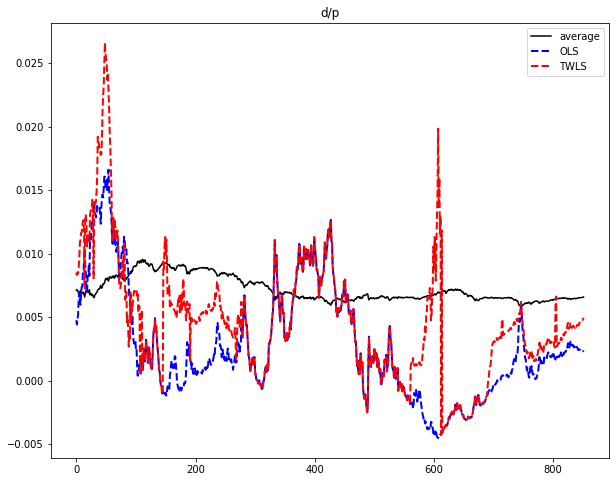

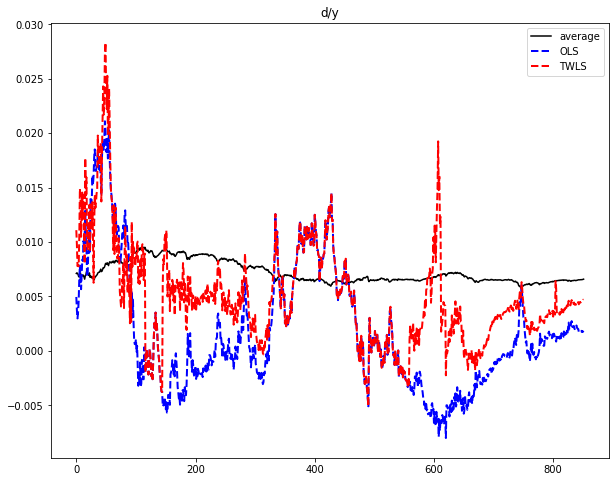

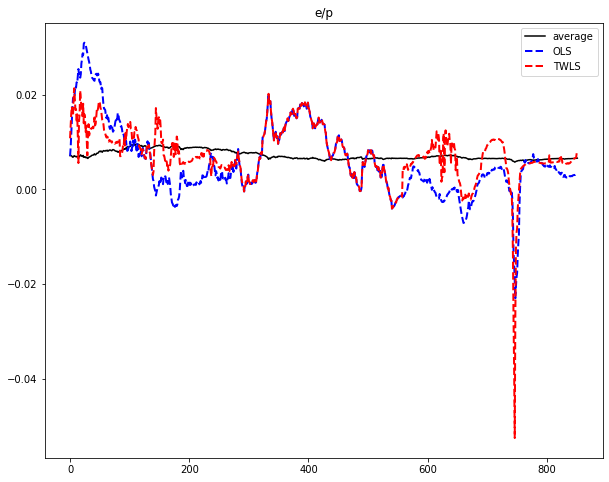

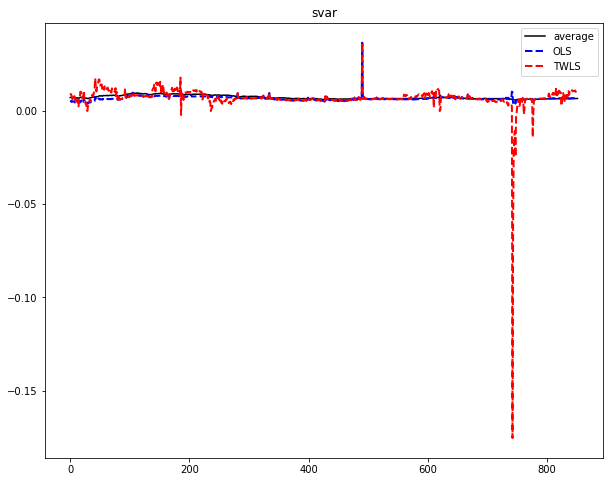

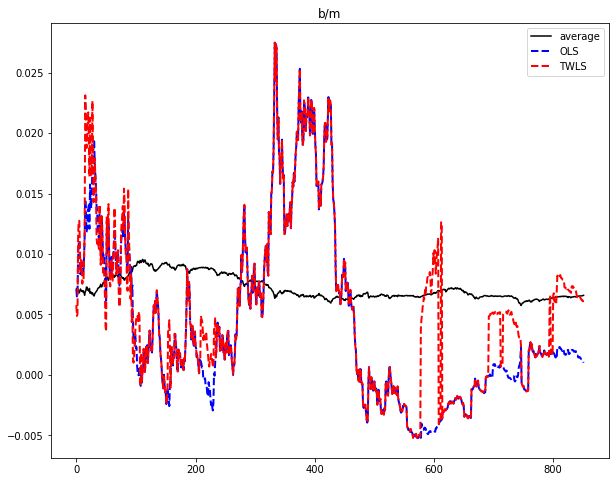

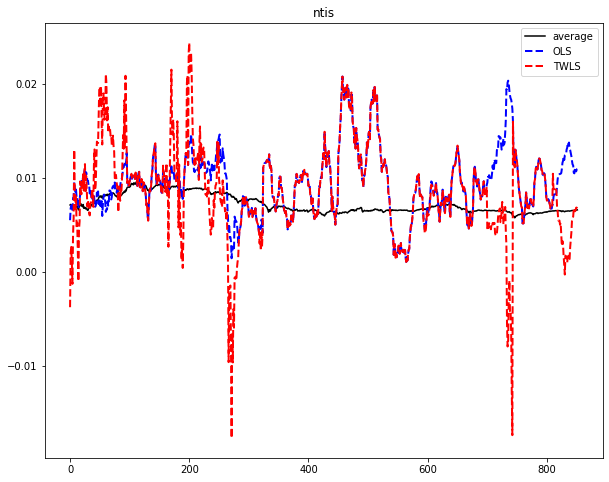

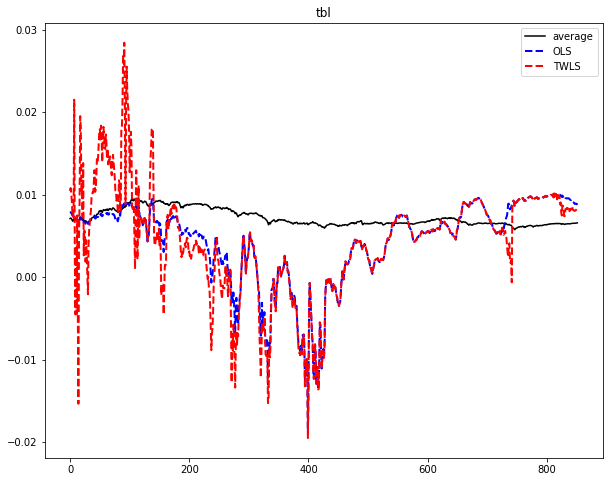

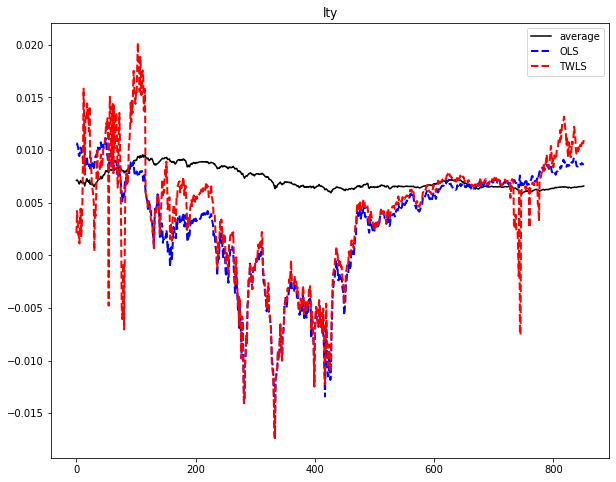

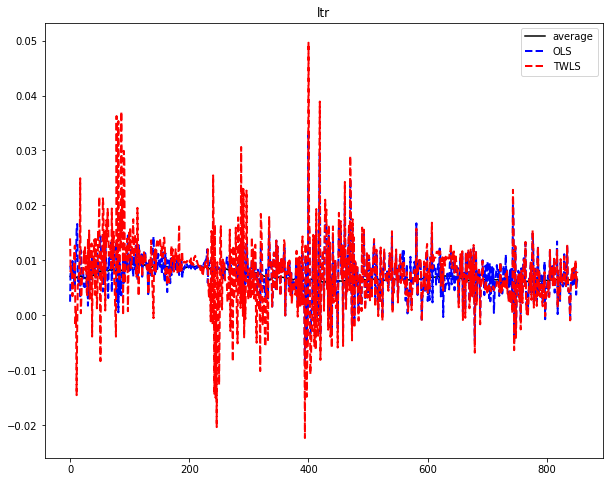

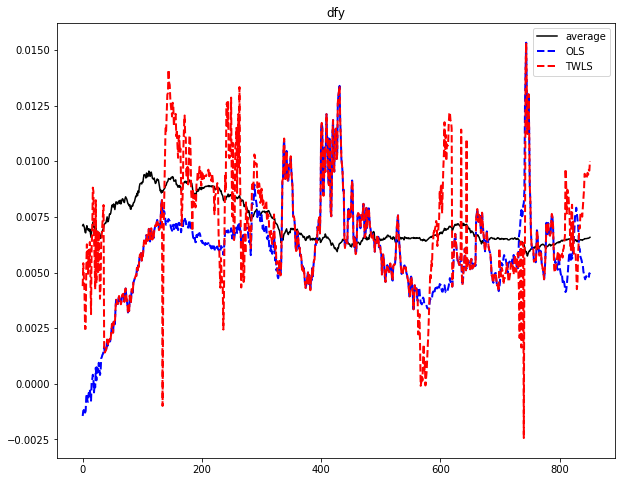

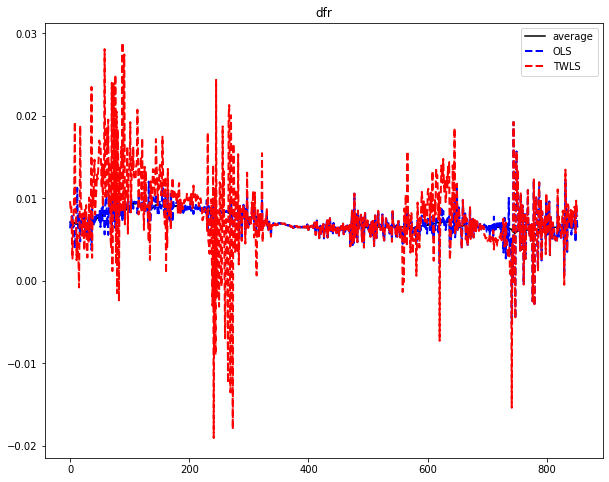

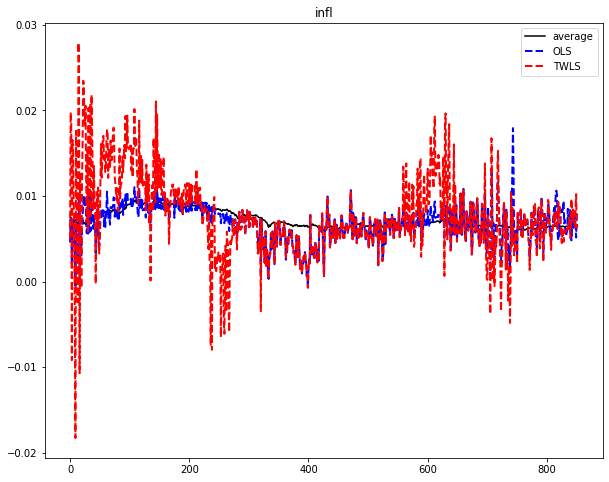

In [36]:
target=['d/p','d/y','e/p','svar','b/m','ntis','tbl','lty','ltr','dfy','dfr','infl']
length=len(df['d/p'])-20*12
sum_ols=[0]*length
sum_twls=[0]*length
for i in target:
    a,b,c,d=main(i)
    sum_ols=[sum_ols[i]+b[i] for i in range(length)]
    sum_twls=[sum_twls[i]+d[i] for i in range(length)]
sum_ols=[sum_ols[i]/12 for i in range(length)]
sum_twls=[sum_twls[i]/12 for i in range(length)]

总和OLS为0.007637577503600612
总和TWLS为0.01553728524300435


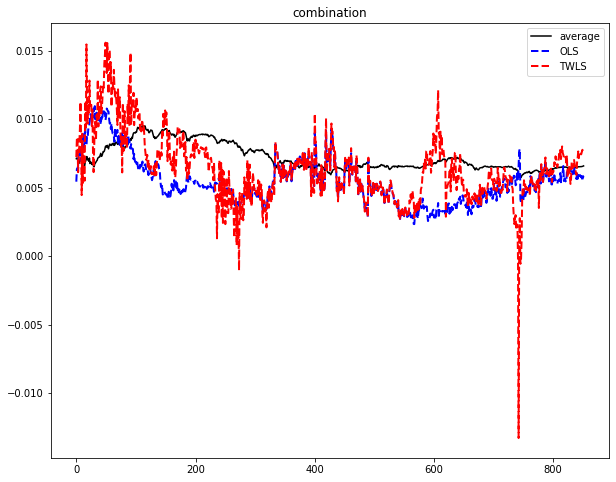

In [37]:
print("总和OLS为"+str(roos(sum_ols)))
print("总和TWLS为"+str(roos(sum_twls)))
fig,ax=plt.subplots(figsize=(10,8))
ax.plot(premium_average,'k-',label='average')
ax.plot(sum_ols,'b--',label="OLS",linewidth=2)
ax.plot(sum_twls,'r--',label="TWLS",linewidth=2)
ax.legend(loc='best')
ax.set_title("combination")
plt.savefig("combination"+'.png')